<a href="https://colab.research.google.com/github/ardnas4/SDP_2022-2023/blob/main/Poison_Plant_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from tensorflow import keras
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np
import tensorflow as tf
from keras.applications import ResNet50

In [2]:
# on Google Colab, get the dataset from drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# unzip the dataset for use
from zipfile import ZipFile
file_name = '/content/drive/MyDrive/Poison Plant Classifier/Dataset.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [4]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import splitfolders

splitfolders.ratio("Dataset", # The location of dataset
                   output="Training_Datasets", # The output location
                   seed=42, # The number of seed
                   ratio=(.8, .2), # The ratio of splited dataset
                   group_prefix=None, # If your dataset contains more than one file like ".jpg", ".pdf", etc
                   move=False # If you choose to move, turn this into True
                   )

Copying files: 10610 files [00:04, 2412.09 files/s]


In [6]:
train_dir = os.path.join('/content/Training_Datasets', 'train')
validation_dir = os.path.join('/content/Training_Datasets', 'val')

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            label_mode='int',
                                                            batch_size=64,
                                                            image_size=(224, 224))

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 label_mode='int',
                                                                 batch_size=64,
                                                                 image_size=(224, 224))

Found 8486 files belonging to 4 classes.
Found 2124 files belonging to 4 classes.


In [14]:
base_model = keras.Sequential()
base_model.add(ResNet50(include_top=False, weights='imagenet', pooling='max'))
base_model.add(Dropout(0.4))
base_model.add(Dense(4, activation='softmax'))

base_model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [15]:
resnet_history = base_model.fit(train_dataset, validation_data = validation_dataset, epochs = 20)

Epoch 1/20
133/133 [==============================] - 97s 694ms/step - loss: 6.7343 - accuracy: 0.3459 - val_loss: 3.0346 - val_accuracy: 0.4873
Epoch 2/20
133/133 [==============================] - 92s 685ms/step - loss: 4.4186 - accuracy: 0.4453 - val_loss: 2.6955 - val_accuracy: 0.5414
Epoch 3/20
133/133 [==============================] - 92s 685ms/step - loss: 2.9689 - accuracy: 0.4649 - val_loss: 2.4407 - val_accuracy: 0.5471
Epoch 4/20
133/133 [==============================] - 92s 683ms/step - loss: 2.4124 - accuracy: 0.4901 - val_loss: 2.0569 - val_accuracy: 0.5508
Epoch 5/20
133/133 [==============================] - 92s 683ms/step - loss: 2.1471 - accuracy: 0.5185 - val_loss: 1.4167 - val_accuracy: 0.5772
Epoch 6/20
133/133 [==============================] - 92s 684ms/step - loss: 1.9742 - accuracy: 0.5355 - val_loss: 1.9113 - val_accuracy: 0.5871
Epoch 7/20
133/133 [==============================] - 92s 683ms/step - loss: 1.7698 - accuracy: 0.5503 - val_loss: 1.3744 - val_ac

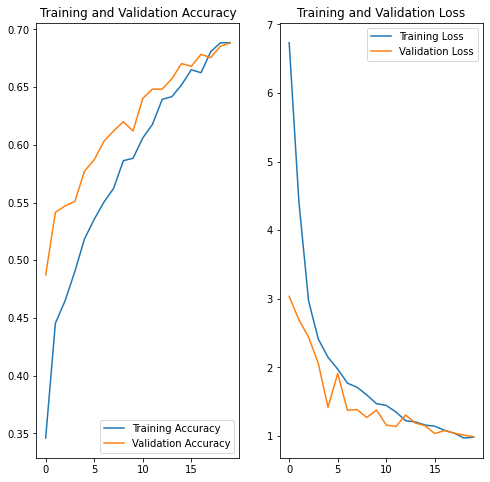

In [16]:
import matplotlib.pyplot as plt

acc = resnet_history.history['accuracy']
val_acc = resnet_history.history['val_accuracy']

loss = resnet_history.history['loss']
val_loss = resnet_history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()